The aim is to make the following experiments:

* train and test a support vector machine classifier through cross-validation;
* study the effect of the parameter gamma of this classifier using a
  validation curve;
* use a learning curve to determine the usefulness of adding new samples in the dataset when building a classifier.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('transfusion.csv')
df.sample(5)

,Recency,Frequency,Monetary,Time,target
222,4,1,250,4,1
634,13,3,750,16,0
473,14,3,750,83,0
119,2,11,2750,79,1
341,23,38,9500,98,0


In [3]:
df.shape

(748, 5)

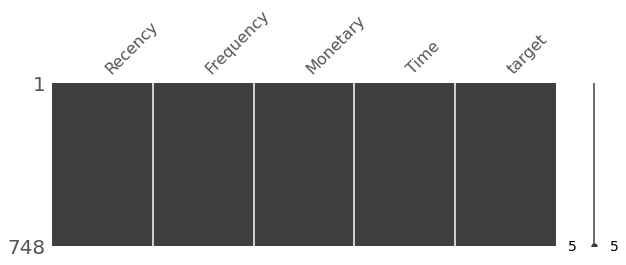

In [4]:
msno.matrix(df, figsize=(10, 3))

In [5]:
data, target = df.drop(columns=['target']), df['target']

In [7]:
target.value_counts()

0    570
1    178
Name: target, dtype: int64

We will use a support vector machine classifier (SVM). In its most simple
form, a SVM classifier is a linear classifier behaving similarly to a logistic regression. Indeed, the optimization used to find the optimal weights of the linear model are different. Also, this classifier can become more flexible/expressive by using a so-called kernel that makes the model become non-linear.

We will use an RBF kernel where a parameter `gamma` allows to tune the
flexibility of the model.

First let's create a predictive pipeline made of:

* a [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  with default parameter;
* a [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  where the parameter `kernel` could be set to `"rbf"`. Note that this is the default.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

Evaluate the generalization performance of your model by cross-validation with
a `ShuffleSplit` scheme. Thus, you can use
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
and pass a
[`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
to the `cv` parameter. Only fix the `random_state=0` in the `ShuffleSplit` and
let the other parameters to the default.


In [10]:
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=30, test_size=.33, random_state=0)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=-1
)

In [12]:
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score,train_score
0,0.023803,0.011428,0.706882,0.735620
1,0.020513,0.010582,0.686632,0.742024
2,0.018699,0.010225,0.611342,0.768996
3,0.019736,0.010095,0.699172,0.739857
4,0.018571,0.010359,0.718535,0.721410
5,0.021195,0.010733,0.725343,0.691715
6,0.018806,0.015008,0.683511,0.730443
7,0.021301,0.011296,0.721544,0.720265
8,0.019221,0.015477,0.694272,0.743816
9,0.019772,0.012992,0.668498,0.752521
